# Data augmentation

The data augmentation algorithm serves two purposes: (1) to simplify an intractable or unwieldy posterior, or (2) better approximate the posterior when we have partially missing data. I demonstrate both purposes below using real examples. But first, I briefly motivate the algorithm (both examples and explanation are adapted from Tanner, 1996).

As explained above, sometimes the analytical form of the posterior $p(\theta | Y)$ might be too complex to compute expectations over, or even sample. Or, we might want to incorporate as much information as possible into the posterior from only partially observed data. In both scenarios, we augment the observed data $Y$ with latent variables $Z$. We take advantage of a tractable augmented posterior $p(\theta | Y, Z)$ to recover $p(\theta | Y)$. Note that if $p(\theta | Y, Z)$ is too complex to work with, we are stuck again. Assuming we can evaluate or sample $p(\theta | Y, Z)$, we can integrate $Z$ out to get $p(\theta | Y)$. We have $$p(\theta | Y) = \int_{Z} p(\theta | Y, Z)p(Z | Y) dZ.$$ We call this the posterior identity. But in order to evaluate the posterior identity and recover $p(\theta | Y)$, we need the form of $p(Z | Y)$. We can write $$p(Z | Y) = \int_{\theta} p(Z | Y, \theta)p(\theta | Y)d\theta.$$ This is the predictive identity. Note that $p(Z | Y)$ depends on $p(\theta | Y)$, and $p(\theta | Y)$ in turn depends on $p(Z | Y)$. Thus, starting at an initial approximation to $p(\theta | Y)$, we can alternate between sampling latent variables $Z$ using the predictive identity, and sampling $\theta$ using the posterior identity. This way, we iteratively improve our approximation to $p(\theta | Y)$. The algorithm works as follows:

(1) Sample $\theta_{1}^{\ast}$, ..., $\theta_{m}^{\ast}$ from the current approximation to the nonaugmented posterior $p(\theta | Y).$ <br>
(2) Sample $z_j$ from the conditional predictive distribution $p(Z | \theta_{j}^{\ast}, Y)$ for each $j = 1, ..., m$. <br>
(3) Update $p(\theta | Y)$ as the mixture of augmented posteriors so that $p(\theta | Y)$ = $\frac{1}{m}$ $\sum\limits_{j=1}^{m} p(\theta | z_j, Y)$. <br>
(4) Repeat steps (1)-(3) until the approximation converges to $p(\theta | Y)$. 

To be clear, at each iteration of the algorithm, we generate $m$ latent variables $Z$. Each $z_j$ for $j = 1, ..., m$ corresponds to an augmented posterior, from which we generate a corresponding $\theta_{j}^{\ast}$. The approximation to the nonaugmented posterior we wish to recover is the mixture of these augmented posteriors. Meaning, our approximation is represented by $\theta_{1}^{\ast}$, ..., $\theta_{m}^{\ast}$, where each $\theta_{j}^{\ast}$ potentially comes from a different augmented posterior distribution. We demonstrate this process concretely below. 

## Simplifying the form of a posterior

We consider the genetic linkage model. Suppose 197 animals are distributed into four categories as follows: $$Y = (y_{1}, y_{2}, y_{3}, y_{4}) = (125, 18, 20, 34)$$ with cell probabilities $$(\frac{1}{2} + \frac{\theta}{4}, \frac{1 - \theta}{4}, \frac{1 - \theta}{4}, \frac{\theta}{4}).$$ Under a flat prior, the posterior distribution is $$p(\theta | Y) \propto (2 + \theta)^{y_{1}}(1 - \theta)^{y_{2} + y_{3}}\theta^{y_4}.$$ Evaluating expectations of this function might be too complex for our liking. Alternatively, as Monte Carlo enthusiasts, we could sample the distribution instead. But unfortunately, we have no way to sample this distribution either. We can, however, simplify its form with data augmentation. 

We augment the observed data $Y$ with a latent variables $Z$. We construct $Z$ by spliting the first cell of $Y$ into two cells. Specifically, $$y_{1} = z_{1} + z_{2}$$  $$y_{2} = z_{3}$$ $$y_{3} = z_{4}$$ $$y_{4} = z_{5}$$ where $Z$ has cell probabilities $$(\frac{1}{2}, \frac{\theta}{4}, \frac{1 - \theta}{4}, \frac{1 - \theta}{4}, \frac{\theta}{4}).$$ Under a flat prior, the augmented posterior is given by $$p(\theta | Y, Z) \propto \theta^{z_{2} + z_{5}}(1 - \theta)^{z_{3} + z_{4}}.$$ The augmented posterior admits a much simpler form. In fact, the augmented posterior is a beta distribution, which yields tractable expectations and direct sampling! Once we have the form for the conditional predictive distribution, we can employ the data augmentation algorithm. 

The conditional predictive distribution for $z_{2}$ is given by $$z_{2} \sim Binom(n = 125, p = \frac{\theta}{\theta + 2}).$$ Intuitively, we are flipping a coin to decide if each of the 125 counts from $y_1$ fall into $z_1$ or $z_2$. And the probability of falling in $z_1$ is of course given by the probability of being in $z_1$ divided by the probability of being in $z_1$ or $z_2$. 

Thus, at each iteration of the algorithm, we generate $\theta_{1}^{\ast}, ..., \theta_{m}^{\ast}$ from the current approximation to the posterior. Then generate $z_{2}^1, ..., z_{2}^m$ from the conditional predictive distribution using each $\theta_{1}^{\ast}, ..., \theta_{m}^{\ast}$. And we update the posterior distribution accordingly by sampling the beta distribution dependent on each $z_{2}^1, ..., z_{2}^m$. We repeat these two steps--impute, then update--until the algorithm converges. At that point, we have a sample from the desired posterior distribution!

Adding labels


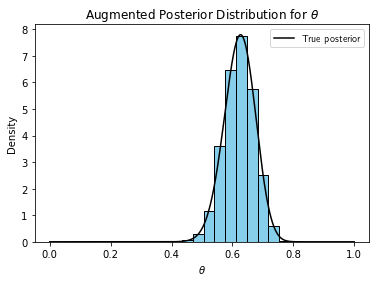

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import norm

y1, y2, y3, y4 = [125, 18, 20, 34]

numIterations = 100
numImputations = 5000
posteriorApproximations = np.zeros([numIterations, numImputations])
randomIndices = random.choices(range(numImputations), k = numIterations)
currentTheta = np.random.uniform(0, 1, numImputations)

for iiIteration in range(numIterations):

    # Generate m imputations / latent variables from the current posterior distribution (represented by a sample of thetas not just one theta)

    currentImputations = np.zeros([numImputations])

    for jjImputation in range(numImputations):

        thetaStar = currentTheta[jjImputation]
        currentImputations[jjImputation] = np.random.binomial(y1, thetaStar / (thetaStar + 2), 1)

    # Now sample theta star from Beta(v1, v2) where v1 = x2 + y4 + 1 and v2 = y2 + y3

    for jjImputation in range(numImputations):

        currentLatentVariable = currentImputations[random.randint(0, numImputations - 1)] # drawn from the conditional predictive distribution given the current approximation to the posterior
        currentTheta[jjImputation] = np.random.beta(currentLatentVariable + y4 + 1, y2 + y3 + 1, 1) # sampling the current approximation to the posterior
        # (which of course depends on the latent variables that in turn depend on the previous approximation to the posterior)
        posteriorApproximations[iiIteration, jjImputation] = currentTheta[jjImputation]


## Plot the true posterior distribution as well 
        
theta = np.linspace(0, 1, 10000)
trueDensity = ((2 + theta) ** y1) * ((1 - theta) ** (y2 + y3)) * (theta ** y4)

# Normalize the true density 

deltaTheta = theta[1] - theta[0]
normalizingConstant = np.sum(deltaTheta * trueDensity)
trueDensity = trueDensity / normalizingConstant

posteriorSample = currentTheta
plt.hist(posteriorSample, density = True, color = 'skyblue', edgecolor = 'black')
plt.plot(theta, trueDensity, color = 'black', label = 'True posterior')
print('Adding labels')
plt.rc('text', usetex = True)
plt.xlabel('$\\theta$')
plt.ylabel('Density')
plt.title('Augmented Posterior Distribution for $\\theta$')
plt.legend()
plt.show()

quantiles = np.array([.025, .50, .975])
convergenceQuantiles = np.quantile(posteriorApproximations, quantiles, axis = 1) 


We can see that the sample from the augmented posterior agrees well with the true analytical posterior. We have made use of the fact that we can easily sample a simplified posterior distribution by augmenting the observed data with latent variables. An animated sample from the final augmented posterior and conditional predictive distribution is shown below to emphasize the interdependence between the augmenting and updating steps. The sample for $\theta$ is shown in black, $x_{2}$ in red. 

In [2]:
# Theta sampler gif

theta_sample = posteriorApproximations[-1, :].flatten()
augmented_sample = currentImputations

import imageio

num_images = 100
image_nums = [int(temp_image) for temp_image in np.linspace(0, np.size(theta_sample), num_images)]
print('Saving images to write to gif')

for ii_index, ii_image in enumerate(image_nums):

    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Imputation')
    ax1.set_ylabel('$\\theta$', color = 'black')
    ax1.plot(theta_sample[:ii_image], color = 'black')
    ax1.set_ylim([0, 1])
    ax1.set_xlim([0, numImputations])

    ax2 = ax1.twinx()
    ax2.set_ylabel('Augmented $x_{2}$', color = 'red')
    ax2.plot(augmented_sample[:ii_image], color = 'red')
    ax2.set_ylim([0, 125])
    plt.suptitle('Samples from Posterior and Conditional Predictive Distribution')
    plt.savefig(f'theta_sampler/temp_fig{ii_index:.0f}.png')
    plt.close()

images = []
filenames = [f'theta_sampler/temp_fig{ii_image:.0f}.png' for ii_image in range(num_images)]

for filename in filenames:

    images.append(imageio.imread(filename))

print('Writing gif')
imageio.mimsave('theta_sampler.gif', images)

Saving images to write to gif
Writing gif


![theta sampler animation](theta_sampler.gif)

We can also see that the posterior distribution converges in just a handful of iterations below. Only in the first few iterations does the posterior meaningfully change. 

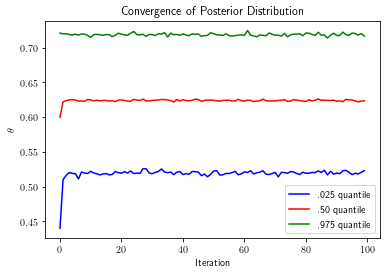

In [3]:
colors = np.array(['blue', 'red', 'green'])
labels = np.array(['.025 quantile', '.50 quantile', '.975 quantile'])

for iiQuantile in range(len(quantiles)):

    plt.plot(convergenceQuantiles[iiQuantile, :], color = colors[iiQuantile], label = labels[iiQuantile])

plt.xlabel('Iteration')
plt.rc('text', usetex = True)
plt.ylabel('$\\theta$')
plt.title('Convergence of Posterior Distribution')
plt.legend()
plt.show()

## Better approximating posterior with right-censored data

Now, moving to the second application of data augmentation, I demonstrate how to better approximate a posterior in cases where we have "missing" or "incomplete" data.  

Our data set is comprised of descriptory statistics for patients who recently had heart transplants. These statistics include how long the patient survived after the heart transplant, and how old the patient was on the day of the transplant. We want to regress log survival time onto age. However, our data set is fairly incomplete: many patients did not die before the end of the study. Since we don't know the true value of their survival time (it will continue to change until they die), we can't incorporate this data into our regression. Using the data augmentation algorithm, we can fill in the missing data and incorporate it into our regression. In fact, doing so will better approximate the joint posterior of the linear regression parameters. The method and data are adapted from Tanner, 1996. We truncate the data intentionally to show the effects of data augmentation in a small sample setting. 

As explained previously, the algorithm works iteratively. To recap, at each iteration, we augment the observed (but incomplete) data by generating our best guess for the values of the missing data. In our case, we do so by generating the residuals for patients who survived longer than the length of the study, conditional on the fact that the residual must be more positive than what we currently observe. We then add these "imputed" residuals to the recorded log survival time to complete the data. Then, we run our regression and update the approximation to the posterior distribution. We repeat these steps until the posterior converges. In the end, we have a sample from a better approximation to the posterior. 

In [4]:
## Import packages and set up parameters

import pandas as pd
import numpy as np
import random
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

stanfordHeartData = pd.read_csv('heart_transplant.csv') # Load data in 

## Regressing log survival time on age to get sample variance of residuals

aliveIndices = stanfordHeartData.index[stanfordHeartData['survived'] == 'alive'].tolist()
deadIndices = stanfordHeartData.index[stanfordHeartData['survived'] == 'dead'].tolist()

# Truncate data
 
truncatedAlive = 28
truncatedDead = 28
aliveIndices = random.sample(aliveIndices, truncatedAlive)
deadIndices = random.sample(deadIndices, truncatedDead)
deadSurvivalTimes = stanfordHeartData['survtime'][deadIndices]
logDeadSurvivalTimes = np.array(np.log(deadSurvivalTimes))
deadAge = np.array(stanfordHeartData['age'][deadIndices])
aliveCensoredEventTimes = stanfordHeartData['survtime'][aliveIndices]
logAliveCensoredEventTimes = np.array(np.log(aliveCensoredEventTimes))
aliveAge = np.array(stanfordHeartData['age'][aliveIndices])
numCensoredEventTimes = len(aliveCensoredEventTimes)
allAge = np.append(deadAge.reshape(-1, 1), aliveAge.reshape(-1, 1), 0)
model = LinearRegression()

# Reshape arrays

deadAgeReshaped = deadAge.reshape(-1, 1)
logDeadSurvivalTimesReshaped = logDeadSurvivalTimes.reshape(-1, 1)
model.fit(deadAgeReshaped, logDeadSurvivalTimesReshaped)
init_beta_0 = model.intercept_[0]
init_beta_1 = model.coef_[0][0]
yHat = model.predict(deadAgeReshaped)
residuals = yHat - logDeadSurvivalTimesReshaped # Flatten  predicted values
nonAugmentedResidualVariance = np.var(residuals)

In [5]:
# Draw error variance from chi square distribution

numObservedData = len(deadSurvivalTimes)
numIterations = 30
numImputations = 5000
currentResidualVariance = (numObservedData - 1) * nonAugmentedResidualVariance / np.random.chisquare(numObservedData - 1, numImputations)
designMatrix = np.ones([numObservedData, 2])
designMatrix[:, 1] = deadAgeReshaped.flatten()
posteriorsOverIterations = np.zeros([numIterations, numImputations, 3])
posteriorsOverIterations[0, :, -1] = currentResidualVariance.reshape(-1, 1).flatten()
numTotalDatapoints = len(stanfordHeartData['age'])
conditionalErrors = np.zeros([numIterations, numCensoredEventTimes])
predictedErrors = np.zeros([numIterations, numCensoredEventTimes])


# Initialize the approximation to the posterior distribution by sampling the error variance
# from the linear regression model that does not include the incomplete data

for iiImputation in range(numImputations):

    varStar = currentResidualVariance[iiImputation]
    covarianceMatrix = np.linalg.inv(varStar * designMatrix.T @ designMatrix) 
    tempBetaStars = np.random.multivariate_normal([init_beta_0, init_beta_1], covarianceMatrix, 1).reshape(1, -1)
    posteriorsOverIterations[0, iiImputation, 0:2] = tempBetaStars


## Now that you have initialized the posterior approximation, you can start the iterative algorithm

augmentedSurvivalTimes = np.zeros([numIterations, numCensoredEventTimes, numImputations]) ## row = data point, column = imputation number
quantiles = np.array([.025, .50, .975])
convergenceBeta0 = np.zeros([len(quantiles), numIterations])
convergenceBeta1 = np.zeros([len(quantiles), numIterations])
convergenceSigmaSq = np.zeros([len(quantiles), numIterations])

for iiIteration in range(numIterations):

    if iiIteration % 10 == 0:

        print('Iteration: ', iiIteration)

    for jjImputation in range(numImputations):

        # Randomly select theta from the mixture of posterior distributions

        randomIndex = random.randint(0, numImputations - 1)
        beta_0_star, beta_1_star, sigma_sq_star = posteriorsOverIterations[iiIteration, randomIndex, :]

        # Generate the augmented data by sampling errors and adding to right censored event time

        for kkCensoredEventTime in range(numCensoredEventTimes):

            predictedSurvivalTime = (beta_0_star + beta_1_star * aliveAge[kkCensoredEventTime])
            norm_predicted_error = (logAliveCensoredEventTimes[kkCensoredEventTime] - predictedSurvivalTime) / np.sqrt(sigma_sq_star)
            predictedErrors[iiIteration, kkCensoredEventTime] = norm_predicted_error
            conditional_error = np.random.normal()

            while conditional_error < norm_predicted_error:

                conditional_error = np.random.normal()

            conditionalErrors[iiIteration, kkCensoredEventTime] = conditional_error
            augmentedSurvivalTimes[iiIteration, kkCensoredEventTime, jjImputation] = logAliveCensoredEventTimes[kkCensoredEventTime] + (conditional_error * np.sqrt(sigma_sq_star))

        # Update the approximation to the posterior 
        # Randomly select the augmented data to use, then do linear regression, then sample error variance, then beta0 and beta1

    for jjImputation in range(numImputations):

        randomIndex = random.randint(0, numImputations - 1)
        tempAugmentedData = augmentedSurvivalTimes[iiIteration, :, randomIndex]
        tempAugmentedDesignMatrix = np.append(np.ones([numCensoredEventTimes, 1]), aliveAge.reshape(-1, 1), 1)
        tempTotalDesignMatrix = np.append(designMatrix, tempAugmentedDesignMatrix, 0)
        tempAugmentedSurvivalTimes = np.append(logDeadSurvivalTimes.reshape(-1, 1), tempAugmentedData.reshape(-1, 1), 0)

        model.fit(tempTotalDesignMatrix[:, -1].reshape(-1, 1), tempAugmentedSurvivalTimes)

        # The posterior for the betas is normal centered around the least squares estimates with covar matrix inv(sample o^2 * X_T @ X)
        
        beta0 = model.intercept_[0]
        beta1 = model.coef_[0][0]
        yHat = model.predict(tempTotalDesignMatrix[:, -1].reshape(-1, 1))
        residuals = yHat - tempAugmentedSurvivalTimes
        sampleResidualVariance = np.var(residuals)
        sigmaSquaredStar = (numTotalDatapoints - 1) * sampleResidualVariance / np.random.chisquare(numTotalDatapoints - 1, 1)

        tempCovarianceMatrix = np.linalg.inv(sigmaSquaredStar * tempTotalDesignMatrix.T @ tempTotalDesignMatrix) 
        betasStar = np.random.multivariate_normal([beta0, beta1], tempCovarianceMatrix, 1).reshape(1, -1)

        if iiIteration < numIterations - 1:

            posteriorsOverIterations[iiIteration + 1, jjImputation, -1] = sigmaSquaredStar
            posteriorsOverIterations[iiIteration + 1, jjImputation, 0:2] = betasStar

convergenceBeta0 = np.quantile(posteriorsOverIterations[:, :, 0], quantiles, axis = 0)
convergenceBeta1 = np.quantile(posteriorsOverIterations[:, :, 1], quantiles, axis = 0)
convergenceSigmaSq = np.quantile(posteriorsOverIterations[:, :, 2], quantiles, axis = 0)

Iteration:  0
Iteration:  10
Iteration:  20


In [6]:
# Plot imputations for the last augmented posterior 

num_images = 200
image_nums = [int(temp_image) for temp_image in np.linspace(0, numImputations - 1, num_images)]
xlims = [np.min(posteriorsOverIterations[-1, :, 1]) - np.std(posteriorsOverIterations[-1, :, 1]), 
              np.max(posteriorsOverIterations[-1, :, 1]) + np.std(posteriorsOverIterations[-1, :, 1])]
ylims = [np.min(posteriorsOverIterations[-1, :, 0]) - np.std(posteriorsOverIterations[-1, :, 0]), 
              np.max(posteriorsOverIterations[-1, :, 0]) + np.std(posteriorsOverIterations[-1, :, 0])]
x = np.linspace(15, 60, 1000)
print('Saving images to write to gif')

for ii_index, ii_image in enumerate(image_nums):

    # Makes most sense to just plot the imputations, but should show a plot similar to the one showed in Tanner
    # That shows the censored event times being augmented by the residual imputations

    plt.figure(figsize = (14, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(aliveAge, augmentedSurvivalTimes[-1, :, ii_image], color = 'red', label = 'Imputed survival time')
    plt.scatter(deadAge, logDeadSurvivalTimes, color = 'black', label = 'Known survival time')
    tempBeta0 = posteriorsOverIterations[-1, ii_image, 0]
    tempBeta1 = posteriorsOverIterations[-1, ii_image, 1]
    plt.plot(tempBeta0 + tempBeta1 * x, color = 'red')
    plt.xlim(15, 60)
    plt.ylim(0, 15)
    plt.title('Augmented Survival Times and Corresponding Regression Line')
    plt.text(0.95, 0.95, f'Imputation {ii_image}', horizontalalignment='right', 
             verticalalignment='top', transform=plt.gca().transAxes)
    plt.xlabel('Age')
    plt.ylabel('Log Survival Time')
    plt.legend(loc = 'upper left')

    plt.subplot(1, 2, 2)
    plt.scatter(posteriorsOverIterations[-1, :ii_image, 1], posteriorsOverIterations[-1, :ii_image, 0], color = 'black')
    plt.scatter(posteriorsOverIterations[-1, ii_image, 1], posteriorsOverIterations[-1, ii_image, 0], color = 'red')
    plt.xlabel('$\\beta_1$')
    plt.ylabel('$\\beta_0$')
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.title('Samples from Augmented Joint Posterior')
    plt.text(0.95, 0.95, f'Imputation {ii_image}', horizontalalignment='right', 
             verticalalignment='top', transform=plt.gca().transAxes, fontsize = 'medium')
    plt.savefig(f'augmented_survival_times/temp_fig{ii_index:.0f}.png')
    plt.close()

images = []
filenames = [f'augmented_survival_times/temp_fig{ii_image:.0f}.png' for ii_image in range(num_images)]

for filename in filenames:

    images.append(imageio.imread(filename))

print('Writing gif')
imageio.mimsave('imputed_survival_times.gif', images)

Saving images to write to gif
Writing gif


We demonstrate how data augmentation works for a fixed iteration of the algorithm. Over 5000 imputations, the plot on the left shows the augmented survival times in red, and the known survival times in black. The corresponding regression line sampled from the augmented posterior is shown in red as well. It corresponds to the red dot on the right. 

![theta sampler imputations](imputed_survival_times.gif)

In [7]:
## Plot the posterior approximations sequentially by iteration 

num_images = numIterations
image_nums = [int(temp_image) for temp_image in np.linspace(0, numIterations - 1, num_images)]
xlims = [np.min(posteriorsOverIterations[:, :, 1]) - 2 * np.std(posteriorsOverIterations[:, :, 1]), 
              np.max(posteriorsOverIterations[:, :, 1]) + 2 * np.std(posteriorsOverIterations[:, :, 1])]
ylims = [np.min(posteriorsOverIterations[:, :, 0]) - 2 * np.std(posteriorsOverIterations[:, :, 0]), 
              np.max(posteriorsOverIterations[:, :, 0]) + 2 * np.std(posteriorsOverIterations[:, :, 0])]
print('Saving images to write to gif')

for ii_index, ii_image in enumerate(image_nums):

    plt.scatter(posteriorsOverIterations[ii_image, :, 1], posteriorsOverIterations[ii_image, :, 0], color = 'black')
    plt.xlabel('$\\beta_1$')
    plt.ylabel('$\\beta_0$')
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.title('Samples from Augmented Joint Posteriors over Time')
    plt.text(0.95, 0.95, f'Iteration {ii_image}', horizontalalignment='right', 
             verticalalignment='top', transform=plt.gca().transAxes)
    plt.savefig(f'theta_sampler_iterations/temp_fig{ii_index:.0f}.png')
    plt.close()

images = []
filenames = [f'theta_sampler_iterations/temp_fig{ii_image:.0f}.png' for ii_image in range(num_images)]

for filename in filenames:

    images.append(imageio.imread(filename))

print('Writing gif')
imageio.mimsave('theta_sampler_iterations.gif', images, duration = .25)

Saving images to write to gif
Writing gif


We also demonstrate below how the augmented posterior changes over each iteration of the algorithm. In our case, the algorithm converges in just a handful of iterations. The augmented posteriors do not change much after the first few iterations. 

![theta sampler iterations](theta_sampler_iterations.gif)

We can see below that the augmented and non-augmented posterior distributions for the y-intercept and the slope are in fact different. The augmented posteriors have increased variance (in both variables), and have substantially different locations. The data augmentation algorithm provides a way to utilize the missing data to our advantage. 

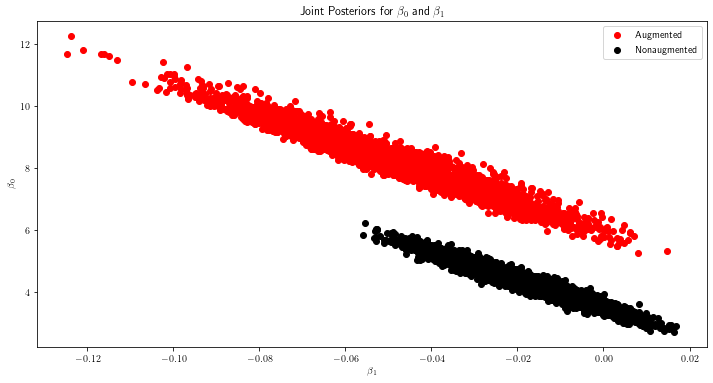

In [8]:
# Plot the joint distribution of beta0 and beta1 together

beta0Distribution = posteriorsOverIterations[-1, :, 0]
beta1Distribution = posteriorsOverIterations[-1, :, 1]

plt.figure(figsize = (12, 6))
plt.scatter(beta1Distribution, beta0Distribution, color = 'red', label = 'Augmented')
plt.xlabel('$\\beta_1$')
plt.ylabel('$\\beta_0$')
plt.title('Joint Posteriors for $\\beta_0$ and $\\beta_1$')

model.fit(deadAgeReshaped, logDeadSurvivalTimesReshaped)
beta0 = model.intercept_[0]
beta1 = model.coef_[0][0]
yHat = model.predict(deadAgeReshaped)
residuals = yHat - logDeadSurvivalTimesReshaped # Flatten the predicted values
nonAugmentedResidualVariance = np.var(residuals)
numSamples = 5000
nonAugmentedPosteriorApprox = np.zeros([numSamples, 3])

for iiSample in range(numSamples):

    nonAugmentedSampleResidualVariance = (numObservedData - 1) * nonAugmentedResidualVariance / np.random.chisquare(numObservedData - 1, 1)
    nonAugCovarMatrix = np.linalg.inv(nonAugmentedSampleResidualVariance * designMatrix.T @ designMatrix)
    betasStar = np.random.multivariate_normal([beta0, beta1], covarianceMatrix, 1).reshape(1, -1)
    nonAugmentedPosteriorApprox[iiSample, 0:2] = betasStar
    nonAugmentedPosteriorApprox[iiSample, -1] = nonAugmentedSampleResidualVariance

beta0Distribution = nonAugmentedPosteriorApprox[:, 0]
beta1Distribution = nonAugmentedPosteriorApprox[:, 1]
plt.scatter(beta1Distribution, beta0Distribution, color = 'black', label = 'Nonaugmented')
plt.xlabel('$\\beta_1$')
plt.ylabel('$\\beta_0$')
plt.legend()
plt.show()

We plot the mean regression lines from the augmented and non-augmented posterior distributions below to better visualize the difference in location and spread of the two posteriors. 

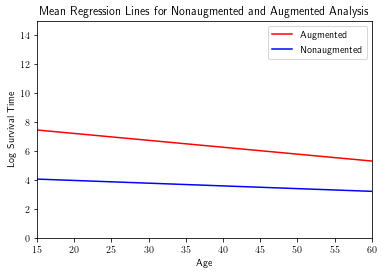

In [9]:
# Plot the mean regression lines for augmented and nonaugmented posterior distributions

x = np.linspace(np.min(deadAge), np.max(deadAge), 1000)
meanAugmentedB0 = np.mean(posteriorsOverIterations[-1, :, 0])
meanAugmentedB1 = np.mean(posteriorsOverIterations[-1, :, 1])
plt.plot(x, meanAugmentedB0 + meanAugmentedB1 * x, color = 'r', label = 'Augmented')
plt.xlabel('Age')
plt.ylabel('Log Survival Time')
plt.title('Mean Regression Lines for Nonaugmented and Augmented Analysis')

meanNonaugmentedB0 = np.mean(nonAugmentedPosteriorApprox[:, 0])
meanNonaugmentedB1 = np.mean(nonAugmentedPosteriorApprox[:, 1])
plt.plot(x, meanNonaugmentedB0 + meanNonaugmentedB1 * x, color = 'blue', label = 'Nonaugmented')
plt.legend()
plt.xlim(15, 60)
plt.ylim(0, 15)
plt.show()

We sample the augmented and non-augmented marginal posterior distributions below for comparison. The marginals deviate from their respective counterparts slightly but noticeably. 

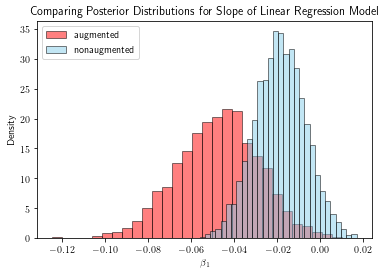

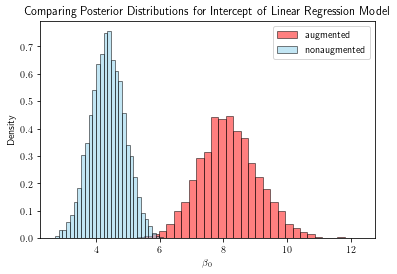

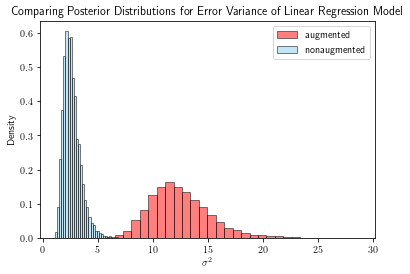

In [10]:
augmentedBeta1Posterior = posteriorsOverIterations[-1, :, 1]
augmentedBeta0Posterior = posteriorsOverIterations[-1, :, 0]
augmentedSigmaSqPosterior = posteriorsOverIterations[-1, :, -1]

# Sample the posterior for the nonaugmented data

plt.hist(augmentedBeta1Posterior, bins = 30, density = True, color = 'red', edgecolor = 'black', alpha = .5, label = 'augmented')
nonAugmentedBeta1Posterior = nonAugmentedPosteriorApprox[:, 1]
plt.hist(nonAugmentedBeta1Posterior, bins = 30, density = True, color = 'skyblue', edgecolor = 'black', alpha = .5, label = 'nonaugmented')
plt.rc('text', usetex = True)
plt.xlabel('$\\beta_1$')
plt.ylabel('Density')
plt.title('Comparing Posterior Distributions for Slope of Linear Regression Model')
plt.legend()
plt.show()

plt.hist(augmentedBeta0Posterior, bins = 30, density = True, color = 'red', edgecolor = 'black', alpha = .5, label = 'augmented')
nonAugmentedBeta0Posterior = nonAugmentedPosteriorApprox[:, 0]
plt.hist(nonAugmentedBeta0Posterior, bins = 30, density = True, color = 'skyblue', edgecolor = 'black', alpha = .5, label = 'nonaugmented')
plt.rc('text', usetex = True)
plt.xlabel('$\\beta_0$')
plt.ylabel('Density')
plt.title('Comparing Posterior Distributions for Intercept of Linear Regression Model')
plt.legend()
plt.show()

plt.hist(augmentedSigmaSqPosterior, bins = 30, density = True, color = 'red', edgecolor = 'black', alpha = .5, label = 'augmented')
nonAugmentedSigmaSqPosterior = nonAugmentedPosteriorApprox[:, -1]
plt.hist(nonAugmentedSigmaSqPosterior, bins = 30, density = True, color = 'skyblue', edgecolor = 'black', alpha = .5, label = 'nonaugmented')
plt.rc('text', usetex = True)
plt.xlabel('$\\sigma^2$')
plt.ylabel('Density')
plt.title('Comparing Posterior Distributions for Error Variance of Linear Regression Model')
plt.legend()
plt.show()